# Extracting edge level noise features 

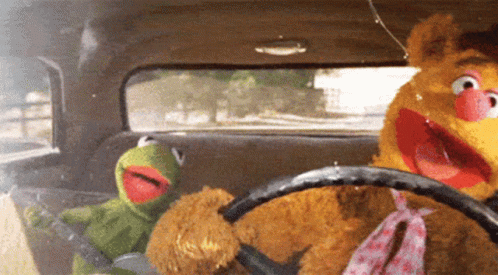 

This notebook details the process of extracting edge level noise features. It builds upon [`experimental/noise.ipynb`](/notebooks/experimental/birds.ipynb) & [`experimental/classifying_edges.ipynb`]('(/notebooks/experimental/classifying_edges.ipynb)'). It contains:

- Data
- Processing
- Exporting data
- **LAV FÆRDIG!!!1**

In [3]:
import pandas as pd
import ast

import geopandas as gpd
import contextily as cx
from shapely.geometry.polygon import Polygon
import osmnx as ox

import matplotlib.pyplot as plt 

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


#### Getting noise values on each edge (road) is a two-step job: 
- The noise data comes with a geometry of polygons, and the edges are linestrings, so the linestrings have to be mapped to the nearest polygon(s). However, the noise data only has information from Copenhagen municipality. 

- Frederiksberg, as well as some roads which not get mapped, are lacking these noise values. To overcome this, we implement a simple RandomForestRegressor to hopefully learn some characteristics about the data, that can be used to predict the noise value from the roads that lack the noise feature. 

## 1) Mapping linestrings to nearest polygons

### Data

The original noise data is visualized here: https://www.kk.dk/borger/affald-og-miljoe/stoej-stoev-og-luft/trafikstoej

The data is aquired from https://www.opendata.dk/city-of-copenhagen/vejstoej_2022 where the chosen dataset is the Nord2000. The reason for choosing Nord2000 over CNOSSOS is that "Miljøstyrelsen" ("The Danish Environmental Protection Agency") says the following:

*CNOSSOS er en simplere og overordnet set mindre nøjagtig model end den vi anvender i Danmark, nemlig beregningsmodellen Nord2000.*

This is roughly translated to:
*CNOSSOS is a simpler, and over all, less accurate model than the one we use in Denmark, namely the Nord2000 model of calculation.*

-----

The edges data comes from OSMNX, getting all roads in Copenhagen- and Frederiksberg municipality in the form of linestrings.

In [6]:
# Reading the data
gdf_noise = gpd.read_file('../data/raw/stoej.json')
gdf_roads = gpd.read_file('../data/raw/edges.json')

KeyboardInterrupt: 

Since this data is located in Denmark, we use CRS _EPSG:25832_ to work with coordinates in metric units.

In [ ]:
# Casting to new epsg in order to use meters in the buffer zone
gdf_noise = gdf_noise.to_crs(epsg=25832)
gdf_roads = gdf_roads.to_crs(epsg=25832)

In [ ]:
# Buffer the roads
gdf_roads['geometry'] = gdf_roads.geometry.buffer(10)

In [ ]:
# Create a spatial index for the noise polygons. A technique to efficiently store and retrieve data based on their geographic location
noise_sindex = gdf_noise.sindex

In [ ]:
# Intersect buffered roads with noise polygons using the spatial index and store intersection results
intersection_results = []
for road in tqdm(gdf_roads.itertuples(), total=len(gdf_roads), desc='Processing roads'):
    possible_matches_i = list(noise_sindex.intersection(road.geometry.bounds))
    possible_matches = gdf_noise.iloc[possible_matches_i]

    road_area = road.geometry.area
    for noise_polygon in possible_matches.itertuples():
        if road.geometry.intersects(noise_polygon.geometry):
            intersection = road.geometry.intersection(noise_polygon.geometry)
            
            if not intersection.is_empty:
                intersection_area = intersection.area

                intersection_results.append({
                    'road_id': road.id,
                    'road_length': road.geometry.length,
                    'noise_id': noise_polygon.id,
                    'intersection_area': intersection_area,
                    'road_area': road_area,
                    'noise_level': noise_polygon.isov1
                })

In [7]:
# Convert the intersection results to a DataFrame
intersections_df = pd.DataFrame(intersection_results)

NameError: name 'intersection_results' is not defined

In [ ]:
# Calculate the total intersection area for each road by summing up 
# the intersection areas of all noise polygons that intersect with the road.
intersection_sums = intersections_df.groupby('road_id')['intersection_area'].sum().reset_index()
intersection_sums.rename(columns={'intersection_area': 'total_intersection_area'}, inplace=True)


In [ ]:
# Merge to get the total intersection area per road
intersections_df = intersections_df.merge(intersection_sums, on='road_id')

In [ ]:
# Calculate normalized intersection percentage
intersections_df['intersection_percentage'] = intersections_df['intersection_area'] / intersections_df['total_intersection_area']

In [ ]:
#Calculate weighted noise based on normalized intersection percentage
intersections_df['weighted_noise'] = intersections_df['noise_level'] * intersections_df['intersection_percentage']

In [ ]:
# Group by road id to sum the weighted noise levels
road_noise = intersections_df.groupby('road_id')['weighted_noise'].sum().reset_index()

In [ ]:
# Merge the noise information back to the original road dataset
gdf_roads['id'] = gdf_roads['id'].astype(str)  # Ensuring 'id' is of the same data type
road_noise['road_id'] = road_noise['road_id'].astype(str)  # Ensuring 'road_id' is of the same data type
gdf_roads = gdf_roads.merge(road_noise, left_on='id', right_on='road_id', how='left').drop(columns=['road_id'])

In [8]:
#Ensure the new 'weighted_noise' does not have NaNs (Frederiksberg data or none mapped linestrings)
gdf_roads['weighted_noise'] = gdf_roads['weighted_noise'].fillna(0)

NameError: name 'gdf_roads' is not defined

Saving the first part of the data (no Frederiksberg data yet). 
This dataset will be used in the moddeling part

In [ ]:
gdf_roads.to_file('../data/noise_cph_no_frb.json')

In [9]:
#Taking a quick glance at the new noise values
gdf_roads[gdf_roads.weighted_noise > 0.0].describe.round(decimals=2)

NameError: name 'gdf_roads' is not defined

In [ ]:
gdf_roads_cph = gdf_roads[gdf_roads.weighted_noise > 0.0]

# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_roads_cph.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_roads_cph.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../pictures/street_noise_map_no_frb.png')


Below are all the roads that did not get assigned any noise levels from the polygons. The big blue cluster is Frederiksberg, which was not part of the noise data. The rest is *probably* small edges that did not get a bigger enough buffer zone to match with any polygons.

NameError: name 'gdf_roads_cph' is not defined

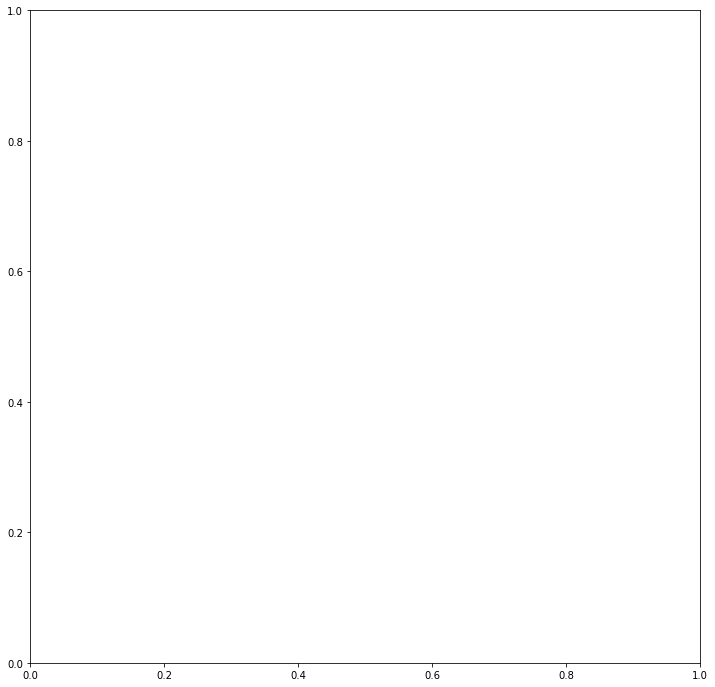

In [11]:
gdf_roads_no_data = gdf_roads[gdf_roads.weighted_noise == 0.0]


# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_roads_cph.plot(
    column='weighted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_roads_cph.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../pictures/street_noise_map_no_frb.png')


## 2) Predicting noise values for linestrings that do not have them

Loading in the data

In [ ]:
#Similar as the first part.
gdf_raw = gpd.read_file('../../data/raw/noise_cph_frb.json')
gdf_raw = gdf_raw.to_crs(epsg=25832)

The edges data, that we used in the first part, are lacking some features that could be useful for model prediction. Therefore, we query OSMNX again to get some features for each linestring.

We'll take a look at the features in a bit

In [12]:
#Getting meta data for each of the raods. Used to more accurate model the noise. 
geocodes = ['Københavns Kommune', 'Frederiksberg Kommune']
G = ox.graph_from_place(geocodes, network_type='bike')
G = ox.project_graph(G, to_crs='EPSG:25832')

# convert graph to geodataframe
_, edges = ox.graph_to_gdfs(G)

#Collabse hierachy structure
edges = edges.reset_index() 

NameError: name 'ox' is not defined

### Data pre-processing

In gdf_raw, the "id" is a tuple of u,v,key. In order to join gdf with the edges dataframe created above, we have to extract u,v,key from the tuble and cast it to new columns


In [ ]:
gdf_raw['id_tuple'] = gdf_raw['id'].apply(ast.literal_eval)
gdf_raw['u'] = gdf_raw['id_tuple'].apply(lambda x: x[0])
gdf_raw['v'] = gdf_raw['id_tuple'].apply(lambda x: x[1])
gdf_raw['key'] = gdf_raw['id_tuple'].apply(lambda x: x[2])

# Dropping the temporary 'id_tuple' column 
gdf_raw.drop(columns=['id_tuple'], inplace=True)

In [13]:
#Merging the new linestring features with the original dataset.
gdf_raw = gdf_raw.merge(edges, how = "right", on=["u","v","key"])

NameError: name 'gdf_raw' is not defined

In [ ]:
#Fill NaNs. This is a very naive approach, and a sort of imputation should be implemented instead, provided we have the time
#Currently, this machine learning part is only a small subset of a bigger project, so we use our time elsewhere
gdf_raw.fillna(0, inplace=True)

In [ ]:
#The columns listed in the 'columns' list, are columns where some of the values are lists
#The RandomForestRegressor wont accept lists as an input, so we get the first value from the list instead

columns = ['highway', 'bridge', 'maxspeed', 'width', 'lanes']
for column in columns:
    gdf_raw[column] = gdf_raw[column].apply(lambda x: x[0] if isinstance(x, list) else x)

In [ ]:
#The highway feature have various string features, which is not accepted by the model
#Therefore, we pick the 4 highest highway values by count, and then OneHot Encode them.
top_4_highways = gdf_raw['highway'].value_counts().nlargest(4).index
gdf_raw['highway'] = gdf_raw['highway'].apply(lambda x: x if x in top_4_highways else 'other')
gdf_processed = pd.get_dummies(gdf_raw, columns=['highway'])


In [15]:
#Defining which features to train on, and what feature to predict

features = [
    'length', 
    'betweenness', 
    'maxspeed', 
    'length', 
    'lanes',  
    'width',
    'highway_other',
    'highway_path',
    'highway_residential',
    'highway_service',
    'highway_tertiary'
]
target = 'weighted_noise'

In [ ]:
#The below three features are of the dtype 'object' and need to be cast to an integer or float

gdf_processed['width'] = pd.to_numeric(gdf_processed['width'], errors='coerce')
gdf_processed['lanes'] = pd.to_numeric(gdf_processed['lanes'], errors='coerce')
gdf_processed['maxspeed'] = pd.to_numeric(gdf_processed['maxspeed'], errors='coerce')

### Setting up the prerequisites for the model

In [ ]:
# Separate rows with and without the target feature
train_data = gdf_processed[gdf_processed[target] > 0.0]
test_data = gdf_processed[gdf_processed[target] == 0.0]

X_train = train_data[features]
y_train = train_data[target]


X_test = test_data[features]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
X_train.dtypes #Ensure we do not have any 'object', 'str', or 'list' datatypes, as the RandomForestRegressor wont accept that

NameError: name 'X_train' is not defined

### Training, evaluation, and prediction

In [ ]:
model = RandomForestRegressor(n_estimators=100,  random_state=42, )
model.fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = model.score(X_val, y_val)


print(f"RMSE: {rmse}, MAE: {mae}, r2: {r2}")

In [ ]:
# Predict the missing values
predictions = model.predict(X_test)

# Assign the predicted values back to the test_data
test_data[target] = predictions

In [17]:
#The only columns we are interested in keeping
gdf_pred = test_data[['u','v','key','predicted_noise','geometry']]

NameError: name 'gdf_ny' is not defined

In [18]:
#Saving the predicted data 
gdf_pred.to_file('../../data/raw/noise_frb_pred.json')

NameError: name 'gdf_pred' is not defined

In [ ]:
# plotting the predicted values and saving them
f, ax = plt.subplots(figsize=(12,12))
gdf_ny.plot(
    column='predicted_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_ny.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../../pictures/street_noise_map_frb_pred.png')


In [ ]:
#Getting the original, none predicited data
gdf_cph = gdf_processed[gdf_processed.weighted_noise > 0.0]

#Casting the data to a geopandas dataframe
gdf_cph = gpd.GeoDataFrame(gdf_cph, geometry='geometry')
gdf_cph.set_crs(epsg=25832, inplace=True)

#Merge the predicted data and the original data together
gdf_combined = gdf_cph.merge(gdf_pred, on=['u','v','key'],how='outer')

In [19]:
#Currently we have two noise columns: weighted and predicted. 
#We want to keep them seperated, such that we always know what is original and what is predicted

#However, we also want a combined column. This is needed for the analysis, as we need one complete noise feature, and not two seperate
gdf_combined['combined_noise'] = gdf_combined['predicted_noise'].combine_first(gdf_combined['weighted_noise'])
gdf_combined['geometry'] = gdf_combined['geometry_x'].combine_first(gdf_combined['geometry_y'])


NameError: name 'gdf_combined' is not defined

In [20]:
#Selecting only the features we need from the combined dataframe. 
#Notice how we do not need the geometry anymore. We have the id in the form of (u,v,key), which can at any time be matched to the edges.json

gdf_combined = gdf_combined[['u','v','key','weighted_noise', 'predicted_noise', 'combined_noise']]
gdf_combined.to_csv('../../data/noise_edges.csv',index=False)

NameError: name 'gdf_combined' is not defined

In [21]:
#If we want to plot the combined data, we yet again have to ensure it's a geopandas dataframe with the proper crs:
abc = gpd.GeoDataFrame(abc, geometry='geometry')
abc.set_crs(epsg=25832, inplace=True)

In [ ]:
# plot streets by noise level
f, ax = plt.subplots(figsize=(12,12))
gdf_combined.plot(
    column='combined_noise',
    scheme='quantiles',
    k=5,
    cmap ='RdYlGn_r',
    ax=ax)
ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=gdf_combined.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.savefig('../../pictures/street_noise_map_final.png')
